In [392]:
import os
import json
import nltk
import string
import numpy as np
import pandas as pd
from unidecode import unidecode
import transformers
import torch
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
from dotenv import load_dotenv

from langchain_community.document_loaders import PDFMinerLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.llms import Ollama
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.chains import RetrievalQA
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline

## Setup metric

In [393]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess(corpus):
  corpus = corpus.lower()
  stopset = nltk.corpus.stopwords.words('english') + nltk.corpus.stopwords.words('russian') + list(string.punctuation)
  tokens = nltk.word_tokenize(corpus)
  tokens = [t for t in tokens if t not in stopset]
  tokens = [lemmatizer.lemmatize(t) for t in tokens]
  corpus = ' '.join(tokens)
  corpus = unidecode(corpus)
  return corpus

In [394]:
embeddings = OllamaEmbeddings(model='llama3')

In [395]:
def embeddings_cosine_sim_metric(expected_answers, predicted_answers):
  results = []

  for expected_answer, predicted_answer in zip(expected_answers, predicted_answers):
    expected_answer = preprocess(expected_answer)
    predicted_answer = preprocess(predicted_answer)

    expected_embedding = np.array(embeddings.embed_query(expected_answer))
    predicted_embedding = np.array(embeddings.embed_query(predicted_answer))

    sim = cosine_similarity(
      expected_embedding.reshape(1, -1),
      predicted_embedding.reshape(1, -1),
    )[0][0]

    results.append(sim)

  return np.mean(results), results

## Load QA dataset

In [396]:
qa_df = pd.read_csv('../research-neurobiology-qa-dataset/brainscape.csv')
qa_df

,question,answer
0,What are the afferent cranial nerve nuclei?,Trigeminal sensory nucleus- fibres carry gener...
1,What is the order of the cranial nerves ?,1-olfactory\n2-optic\n3-oculomotor\n4-trochlea...
2,What are the efferent cranial nerve nuclei?,Edinger-westphal nucleus\nOculomotor nucleus\n...
3,Which nuclei share the embryo logical origin -...,Oculomotor nucleus Trochlear nucleus Abducens ...
4,Which nuclei share the embryo logical origin- ...,Trigeminal motor nucleus Facial motor nucleus ...
...,...,...
1047,What is the purpose of gephyrin in the glycine...,Involved in anchoring the receptor to a specif...
1048,What is the glycine receptor involved in ?,Reflex response\nCauses reciprocal inhibition ...
1049,What happens in hyperperplexia ?,It’s an exaggerated reflex Often caused by a m...
1050,What is hyperperplexia treated with ?,Benzodiazepine


## Setup LLMs

In [397]:
def get_llama3_llm():
  return Ollama(temperature=0, model='llama3')

## Setup index stores

In [398]:
def get_doc_array_vector_store(docs=[]):
  index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeddings,
  ).from_documents(docs)
  return index.vectorstore

## Setup experiments

In [399]:
llms = [
  ('LLaMA 3', get_llama3_llm()),
]

vector_stores = [
  ('DocArray', get_doc_array_vector_store),
]

In [400]:
from langchain.prompts import (
    ChatPromptTemplate,
    FewShotChatMessagePromptTemplate,
)
example_prompt_template = """
Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
Question: {question}
"""
few_shot_examples = [
  {
    "question": "Which cranial nerves are motor?",
    "answer": "Oculomotor\nTrochlear \nAbducens\nAccessory\nHypoglossal"
  },
  {
    "question": "ich of the cranial nerves have both sensory and motor control ?",
    "answer": "TrigeminalFacial GlossopharyngealVagus"
  },
  {
    "question": "Which regions of the cross section of the spinal cord have a larger ventral horn ?",
    "answer": "The cervical and lumbar regions have larger ventral horns. The thoracic region has a smaller ventral horn region because it controls the trunk so not many motor neurones are coming out. Thoracic region has a more prominent lateral horn where preganglionic neurones are present"
  },
  {
    "question": "What are the subdivisions of the vertebral column ?",
    "answer": "Cervical = 8\nThoracic= 12\nLumbar=5 \nSacral=5 \nCoccygeal"
  },
]
example_prompt = ChatPromptTemplate.from_messages(
  [
    ("human", example_prompt_template),
    ("ai", "{answer}\n"),
  ],
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
  example_prompt=example_prompt,
  examples=few_shot_examples,
  input_variables=["question"],
)
base_prompt = ChatPromptTemplate.from_template("""
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
You answer in very short sentences and do not include extra information.

{context}

Question: {question}
Helpful Answer:"
""")
final_prompt = ChatPromptTemplate.from_messages(
  [
    few_shot_prompt,
    base_prompt
  ]
)

In [401]:
sample_df = qa_df[:40]
questions = sample_df['question'].tolist()
expected_answers = sample_df['answer'].tolist()

llm = get_llama3_llm()
vector_store = get_doc_array_vector_store([])
qa_llm = RetrievalQA.from_chain_type(
  llm=llm,
  chain_type='stuff',
  retriever=vector_store.as_retriever(search_kwargs={"k" : 10}),
  verbose=False,
  chain_type_kwargs = {
    'prompt': final_prompt,
    'document_separator': '<<<<<>>>>>'
  },
)

predicted_answers = []

for index, question in tqdm(enumerate(questions), desc='Questions', leave=False):
  answer = qa_llm.invoke(question)['result']
  predicted_answers.append(answer)

accuracy, results = embeddings_cosine_sim_metric(expected_answers, predicted_answers)
accuracy

0.5859193451762141

In [402]:
for expected_answer, predicted_answer, result in zip(expected_answers, predicted_answers, results):
  print(result)
  print(expected_answer)
  print(predicted_answer)
  print()

0.5931178953240189
Trigeminal sensory nucleus- fibres carry general sensory info (pain, touch, pressure, temperature) and terminate at this nucleus Vestibular and cochlear nucleus- fibres carrying special senses of hearing and positional sense run in the vestibulocochlear nerve to these nuclei Nucleus solitarius - visceral afferents terminate at this nucleus of the medulla
Oculomotor, Trochlear, Abducens, Trigeminal, Facial, Glossopharyngeal, Vagus.

0.5941926252779224
1-olfactory\n2-optic\n3-oculomotor\n4-trochlear\n5-trigeminal \n6-abducens\n7-facial\n8-vestibulocochlear\n9-glossopharyngeal\n10-vagus\n11-accessory\n12-hypoglossal
I'll keep my answers brief!

The order of the cranial nerves is: Olfactory, Optic, Oculomotor, Trochlear, Trigeminal, Abducens, Facial, Auditory-Vestibular, Glossopharyngeal, Vagus, Spinal Accessory, Hypoglossal.

0.4352944087757432
Edinger-westphal nucleus\nOculomotor nucleus\nTrochlear nucleus\nTrigeminal motor nucleus \nAbducens nucleus \nFacial motor nuc

<Axes: ylabel='Count'>

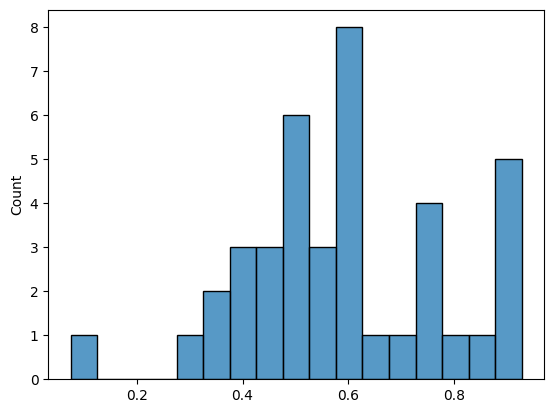

In [403]:
sns.histplot(results, binwidth=0.05)

In [404]:
np.median(qa_df['answer'].map(len))

94.5